<h1> Parcial 1 
    
<h3> Fidel Alejandro Navarro Salazar 
  

 En este trabajo se utilizara un archivo de datos obtenidos de keras, los datos pueden ser consultados por medio del link:
     https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
    
Los datos contienen la información de distintos pacientes, esta información incluye:
     
1) id : identificación del paciente

2) gender : genero dividido en las categorías "Male", "Female", "Other 

3) age : edad del paciente

4) hypertension : se clasifican como 0 si no tiene hipertensión, 1 si tiene hipertensión

5) heart_disease : se clasifica como 0 si no padece de ninguna enfermedad del corazón, 1 si padece alguna enfermedad del corazón

6) ever_merried : se clasifica como "Yes" o "No"

7) work_type : las clasificación del trabajo se clasifica como "children", "Govt_jov", "Never_worked", "Private", "Self-employed"

8) Residence_type : la residencia se clasifica como "Rural" o "Urban"

9) avg_glucose_level : nivel promedio de glucosa en la sangre

10) bmi : índice de masa corporal 

11) smoking_status : se clasifica en "formerly smoked", "never smoked", "unknown"

12) stroke : se clasifica como 1 si el paciente a tenido un derrame cerebral o 0 si no ha tenido

Con estos datos se busca predecir la probabilidad de que un paciente sufra de un derrame cerebral (stroke) dada su información médica.


In [1]:
#Establecemos las librerias a utilizar
#Cargaremos las librerías de pandas, numpy y matplotlib con la finalidad de hacer uso de arrays, DataFrames y graficar los datos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Importamos las distintas funciones de sklearn que utilizaremos para dar formato a nuestros datos
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#Importamos las funsiones de keras y tensorflow a utilizar en la construcción y entrenamiento de nuestra red neuronal
from keras.optimizers import SGD
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau

Primeramente almacenaremos los datos a utilizar

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
print("Trabajaremos con la información de ", len(data), " pacientes.")
print("")
data.head()

Trabajaremos con la información de  5110  pacientes.



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


En la tabla de arriba podemos observar los distintos datos que se nos proporciona en la muestra. 

Bajo una primera lectura de los datos concluímos que es prudente eliminar la columna "id" ya que no representa una variable de interes para el entrenamiento de la red neuronal.

In [3]:
#Eliminaremos la columna de "id"
data.drop("id", axis=1, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


De la información de los datos sabemos que la variable "smoking_status" se clasifica como "smokes", "formerly smoked", "never smoked", "unknown", por lo tanto se remplazará la etiqueta de "unknown" por valores NAN.

In [4]:
#Buscaremos valores faltantes
#Clasificaremos a los valores desconocidos como faltantes (NaN)
data.replace("Unknown", np.nan, inplace=True)

data.isna().sum()

gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

Podemos observar que tenemos un total de 201 valores faltantes de "bmi" y 1544 de "smoking_status". Con la finalidad de no eliminar ninguna columna se cambiaran los valores desconocidos de "smoking status" por un 0, y los valores de "bmi" al ser pocos los faltantes se remplazaran los valores faltantes con el promedio de los datos. 


En una sección posterior se entrenará a la neurona sin utilizar la variable "smoking_status" y en otro caso sin ambas variables ("smoking_status" y "bmi")

In [5]:
#Vemos que bmi y smoking_status son variables que tiene valores faltantes
#por lo tanto le daremos valores de 0 a smoking_status
#como a "bmi" le faltan pocos valores en comparación de el total de datos (5000+)
#en lugar de eliminar la columna llenaremos los datos faltantes con el promedio
data['bmi'].fillna(data['bmi'].mean(), inplace=True)
data['smoking_status'].fillna(data['smoking_status'].mode()[0], inplace = True)

data.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [6]:
#sns.countplot(x = data['smoking_status'])

Debido a que en nuestros datos algunas variables se clasifican por medio caractéres utilizaremos etiquetas para poder utilizar estas variables en nuestra red neuronal.

In [7]:
#Traducimos nuestras variables a un código de etiquetas
#por ejemplo Masculino = 1, Femenino = 0, Otro = 2
LE = LabelEncoder()
en_data = data.apply(LE.fit_transform)
en_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,88,0,1,1,2,1,3850,240,0,1
1,0,82,0,0,1,3,0,3588,162,1,1
2,1,101,0,1,1,2,0,2483,199,1,1
3,0,70,0,0,1,2,1,3385,218,2,1
4,0,100,1,0,1,3,0,3394,113,1,1


Con la finalidad de observar la relación de nuestras variables untilizaremos un mapa de calor (heat map). 

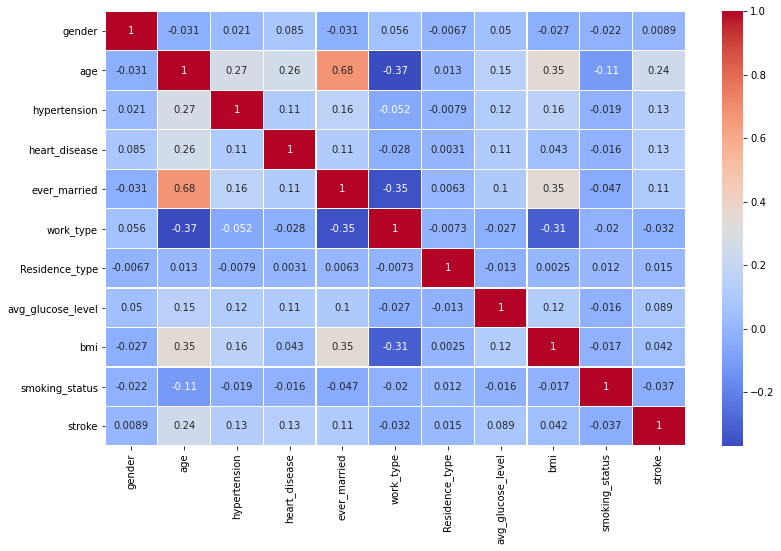

In [8]:
#Observamos las correlaciones entre variables
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
ax = sns.heatmap(en_data.corr(),annot=True,cmap='coolwarm',linewidths=0.2)
plt.show()

Podemos observar que a simple vista pareciece que ninguna de las variables pareciera tener corelación con "stroke" (derrame cerebral).

Ahora dividiremos nuestras diferentes variables en variables independientes (x) y variables dependientes (y : stroke).

In [9]:
#Dividimos nuestros datos entre variables dependientes e independientes
x = en_data.drop("stroke", axis=1)
y = en_data["stroke"]

Dividiremos nuestras variables en muestras de entrenamiento (75%) y prueba (25%).

In [10]:
#Establecemos los datos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=451, stratify=y)

print("Datos de entrenamiento: ", len(x_train))
print("Datos de prueba: ", len(x_test))

Datos de entrenamiento:  3832
Datos de prueba:  1278


Ahora normalizaremos los valores de las distinatas variables entre 0 y 1 con la finalidad de obtener un mejor desempeño de la red neuronal.

In [11]:
#Estandarizaremos los valores de nuestras variables en un array

x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

print("Training Data :", x_train.shape)
print("Test Data :", x_test.shape)

x_train

Training Data : (3832, 10)
Test Data : (1278, 10)


array([[0.        , 0.66019417, 0.        , ..., 0.18376068, 0.18509615,
        0.5       ],
       [0.        , 0.53398058, 0.        , ..., 0.52589241, 0.35096154,
        0.5       ],
       [0.5       , 0.85436893, 0.        , ..., 0.52614379, 0.38461538,
        0.5       ],
       ...,
       [0.        , 0.33009709, 0.        , ..., 0.15912519, 0.24038462,
        0.5       ],
       [0.5       , 0.31067961, 0.        , ..., 0.32403218, 0.30288462,
        0.5       ],
       [0.5       , 0.32038835, 0.        , ..., 0.93137255, 0.29807692,
        0.5       ]])

Posteriormente, definiremos nuestra red neuronal.

In [12]:
#Creamos nuestro modelo
#activ es una variable (string) con la cual podemos controlar la función de activación a utilizar
#hidd nos da el número de capas ocultas a utilizar
def create_model(activ, hidd, drop):
    model = Sequential()
    # Hidden layer
    for i in range(hidd):
        model.add(Dense(10, input_dim=10,activation=activ))
    if drop != 0 :
        model.add(Dropout(drop))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile a model
    model.compile(loss='binary_crossentropy', 
                  optimizer=SGD(learning_rate, momentum),
                  metrics=['accuracy'])
    return model


#Definimos una función que entrene la red neuronal con los datos e hipermarámetros que le demos
def red(x_train, x_test, y_train, y_test, training_epochs, learning_rate, momentum, activ, hidd, drop):
    model = create_model(activ, hidd, drop)
    model.summary()

    results = model.fit(
        x_train, y_train,
        epochs=training_epochs,
        validation_data=(x_test, y_test), verbose=0)

    print("Evaluating on training set...")
    (loss, accuracy) = model.evaluate(x_train, y_train, verbose=0)
    print("loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy*100))
    
    print("Evaluating on tests set...")
    (loss, accuracy) = model.evaluate(x_test, y_test, verbose=0)
    print("loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy*100))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    ax1.plot(results.history["accuracy"])
    ax1.plot(results.history["val_accuracy"])
    ax1.set_title("model accuracy")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("accuracy")
    ax1.legend(["train", "test"])
    
    ax2.plot(results.history["loss"])
    ax2.plot(results.history["val_loss"])
    ax2.set_title("model loss")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("loss")
    ax2.legend(["train", "test"])
    plt.show()

    max_loss = np.max(results.history["loss"])
    min_loss = np.min(results.history["loss"])
    print("Maximum Loss : {:.4f}".format(max_loss))
    print("")
    print("Minimum Loss : {:.4f}".format(min_loss))
    print("")
    print("Loss difference : {:.4f}".format((max_loss - min_loss)))
    print("")
    print("Comparamos los resultados al evaluar la muestra de prueba con los valores reales")
    ynew = pd.DataFrame(model.predict_classes(x_test))
    yold = pd.DataFrame(y_test)
    yold = yold.reset_index(drop=True)
    
    print(classification_report(yold, ynew))

Realizaremos un primer entrenamiento y evaluación de nuestra red neuronal con los hiperparámetros:

training_epochs = 100

learning_rate = 0.1

momentum = 0.9

Además se utilizará 1 hidden layer y la función de activación relu (Rectified Linear Unit)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.1559, accuracy: 95.1200%
Evaluating on tests set...
loss=0.1565, accuracy: 95.1487%


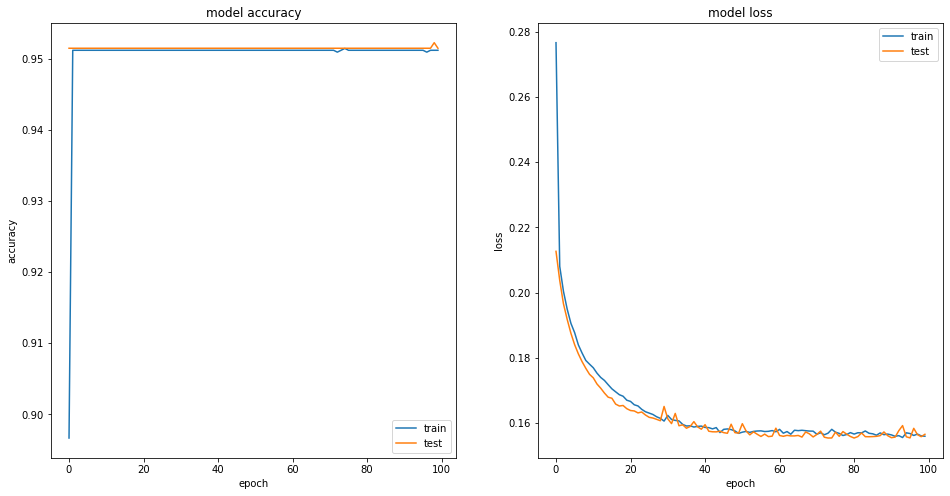

Maximum Loss : 0.2766

Minimum Loss : 0.1555

Loss difference : 0.1211

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



C:\Users\fidel\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\fidel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
#Función de activación
activ = "relu" #"sigmoid" o "relu"
#Número de hidden layers
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 0.9

red(x_train, x_test, y_train, y_test, training_epochs, learning_rate, momentum, activ, hidd, drop)

Podemos observar que cuenta con una buena precisión de 95.12%, sin embargo, el modelo no es capaz de predecir si un paciente tendra un "stroke".

Probaremos con los mismos datos pero ahora utilizando la función de activación "sigmoid".

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.1630, accuracy: 95.1200%
Evaluating on tests set...
loss=0.1579, accuracy: 95.1487%


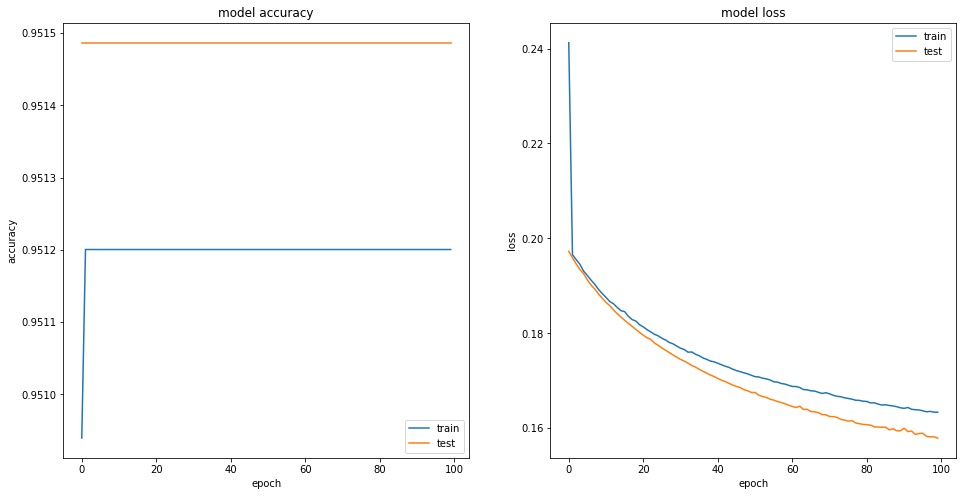

Maximum Loss : 0.2412

Minimum Loss : 0.1634

Loss difference : 0.0779

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



In [14]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 0.9

red(x_train, x_test, y_train, y_test, training_epochs, learning_rate, momentum, activ, hidd, drop)

Apesar de cambiar la función de activación los resultados se mostraron iguales, y no mostró mejora en la predicción.

Ahora utilizaremos la misma función de activación e hiperparámetros pero no incorporaremos la información faltante.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.1379, accuracy: 95.7349%
Evaluating on tests set...
loss=0.1523, accuracy: 95.7655%


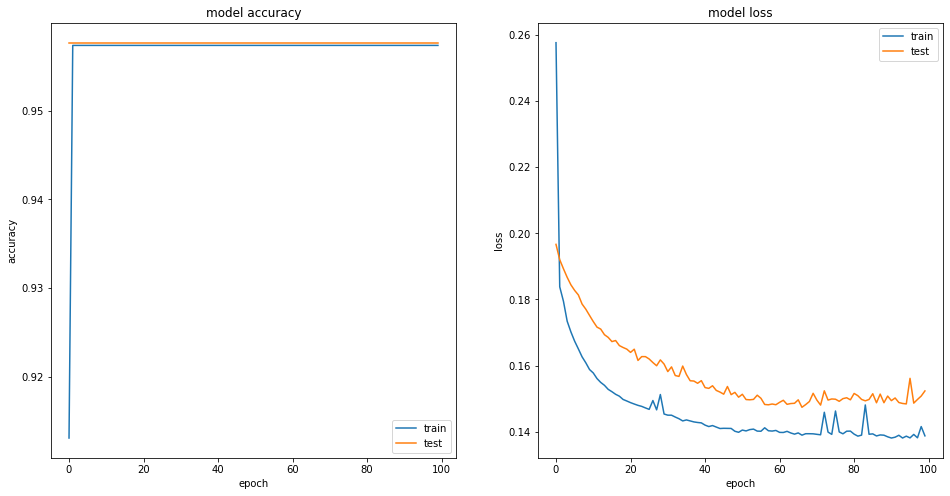

Maximum Loss : 0.2576

Minimum Loss : 0.1381

Loss difference : 0.1196

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1176
           1       0.00      0.00      0.00        52

    accuracy                           0.96      1228
   macro avg       0.48      0.50      0.49      1228
weighted avg       0.92      0.96      0.94      1228



C:\Users\fidel\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\fidel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
data2 = pd.read_csv("healthcare-dataset-stroke-data.csv")
data2.drop("id", axis=1, inplace=True)
data2 = data2.dropna()
en_data2 = data2.apply(LE.fit_transform)

x2 = en_data2.drop("stroke", axis=1)
y2 = en_data2["stroke"]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.25, random_state=451, stratify=y2)

x_train2 = MinMaxScaler().fit_transform(x_train2)
x_test2 = MinMaxScaler().fit_transform(x_test2)

#Función de activación
activ = "relu" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 0.9

red(x_train2, x_test2, y_train2, y_test2, training_epochs, learning_rate, momentum, activ, hidd, drop)

Se puede observar que al eliminar los pacientes con datos incompletos la presición aumento a 95.73%, pero no seguimos viendo mejora en la predicción.

El problema en la predición se puede dar debido a que la mayoria de los valores de "stroke" son 0, eso explicaría la alta presición del modelo.

C:\Users\fidel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


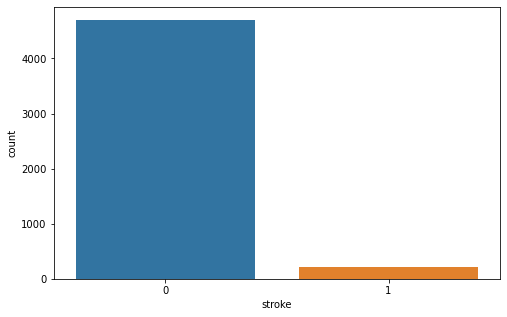

In [16]:
plt.figure(figsize=(8,5))
sns.countplot(y2)
plt.show()

In [17]:
data3 = data[data['stroke'] == 1]
data3 = data3.reset_index(drop=True)
print("El número total de datos son ", len(data))
print("El número de datos con stroke==1 son ",len(data3))

El número total de datos son  5110
El número de datos con stroke==1 son  249


Podemos observar que solamente 249 valores son de pacientes que han sufrido de un derrame cerebral (stroke).

Por lo tanto, para compensar esta falta de valores positivos se disminuiran los datos con stroke==0. Se utilizará en su totalidad los 249 de stroke==1 y 251 datos con stroke==0 con la finalidad de tener una muestra similar para ambos casos y una muestra total de 500 pacientes.

In [18]:
data4 = data[data['stroke'] == 0]
data4 = data4.reset_index(drop=True)
print("El número de datos con stroke==0 son ",len(data4))

El número de datos con stroke==0 son  4861


In [19]:
data4 = data4[0:251]
print("Número de datos con stroke==0  a utilizar son ",len(data4))

Número de datos con stroke==0  a utilizar son  251


Combinaremos las listad de datos "data3" y "data4".

In [20]:
data5 = pd.concat([data3, data4], ignore_index=True)
data5

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
495,Female,71.0,0,0,Yes,Private,Urban,93.28,34.700000,never smoked,0
496,Male,5.0,0,0,No,children,Rural,122.19,35.000000,never smoked,0
497,Female,14.0,0,0,No,children,Rural,129.53,21.300000,never smoked,0
498,Female,15.0,0,0,No,children,Rural,114.53,29.100000,never smoked,0


Ahora que tenemos nuestra nueva muestra procederemos a obtener los valores de entrenamiento y prueba

In [21]:
data5 = data5.dropna()
en_data5 = data5.apply(LE.fit_transform)

x5 = en_data5.drop("stroke", axis=1)
y5 = en_data5["stroke"]
x_train5, x_test5, y_train5, y_test5 = train_test_split(x5, y5, test_size=0.25, random_state=42, stratify=y5)

x_train5 = MinMaxScaler().fit_transform(x_train5)
x_test5 = MinMaxScaler().fit_transform(x_test5)

Ya teniendo nuestras muestras entrenamos a nuestra red neuronal.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.5319, accuracy: 73.0667%
Evaluating on tests set...
loss=0.5220, accuracy: 76.8000%


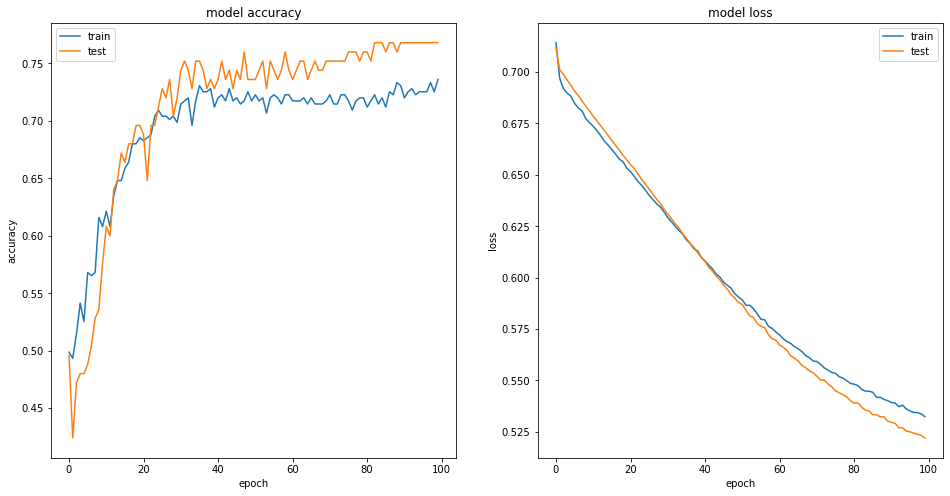

Maximum Loss : 0.7143

Minimum Loss : 0.5324

Loss difference : 0.1819

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        63
           1       0.73      0.84      0.78        62

    accuracy                           0.77       125
   macro avg       0.77      0.77      0.77       125
weighted avg       0.77      0.77      0.77       125



C:\Users\fidel\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [22]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Podemos observar que ahora la precisión a disminuido pero nuestro modelo ahora es capaz de predecir si un paciente tendra un derrame cerebral (stroke).

Posteriormente se entrenará la red neuronal utilizando distintos hiperparámetros.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.6455, accuracy: 71.2000%
Evaluating on tests set...
loss=0.6429, accuracy: 73.6000%


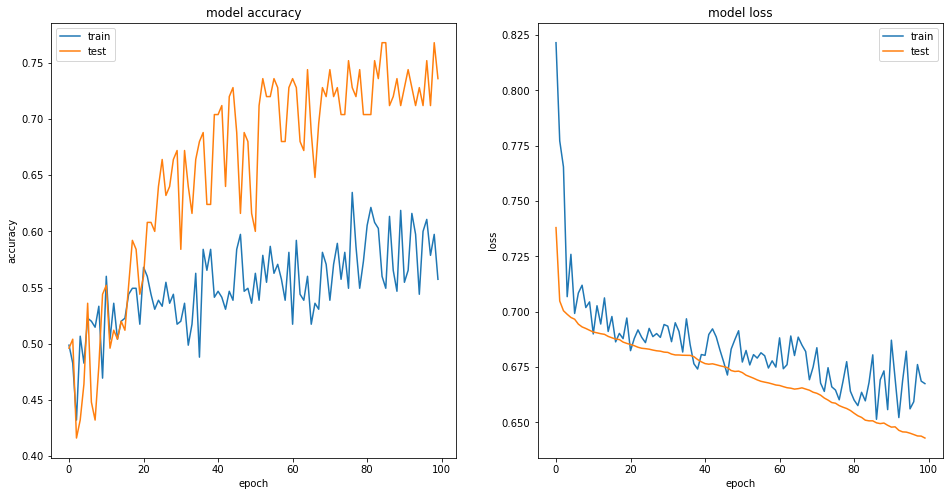

Maximum Loss : 0.8216

Minimum Loss : 0.6514

Loss difference : 0.1702

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.83      0.60      0.70        63
           1       0.68      0.87      0.77        62

    accuracy                           0.74       125
   macro avg       0.75      0.74      0.73       125
weighted avg       0.76      0.74      0.73       125



In [23]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.5
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Al cambiar el dropout vemos que la precisión del modelo disminuye y sobre todo disminuye la precisión con la que predice los valores para stroke==1.

Ahora probaremos cambiando el learning rate.

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.5531, accuracy: 72.8000%
Evaluating on tests set...
loss=0.5474, accuracy: 74.4000%


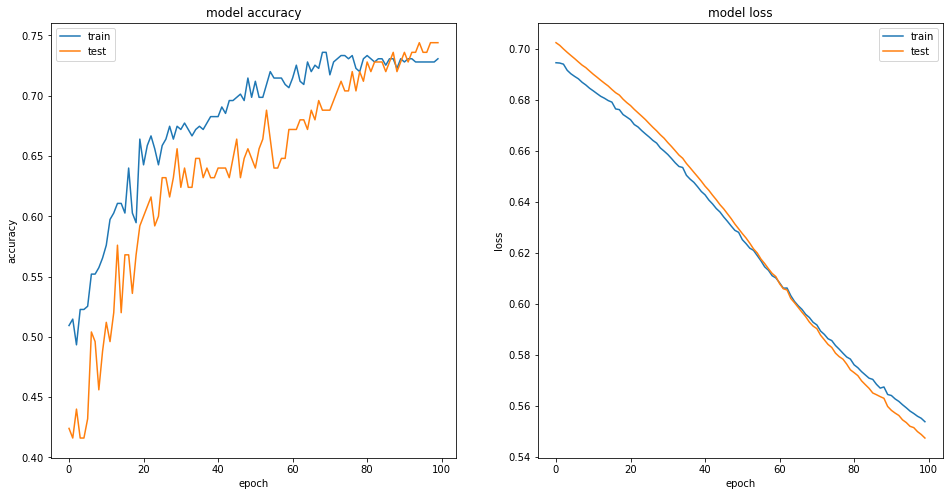

Maximum Loss : 0.6946

Minimum Loss : 0.5538

Loss difference : 0.1408

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        63
           1       0.72      0.79      0.75        62

    accuracy                           0.74       125
   macro avg       0.75      0.74      0.74       125
weighted avg       0.75      0.74      0.74       125



In [35]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.4884, accuracy: 74.1333%
Evaluating on tests set...
loss=0.4992, accuracy: 77.6000%


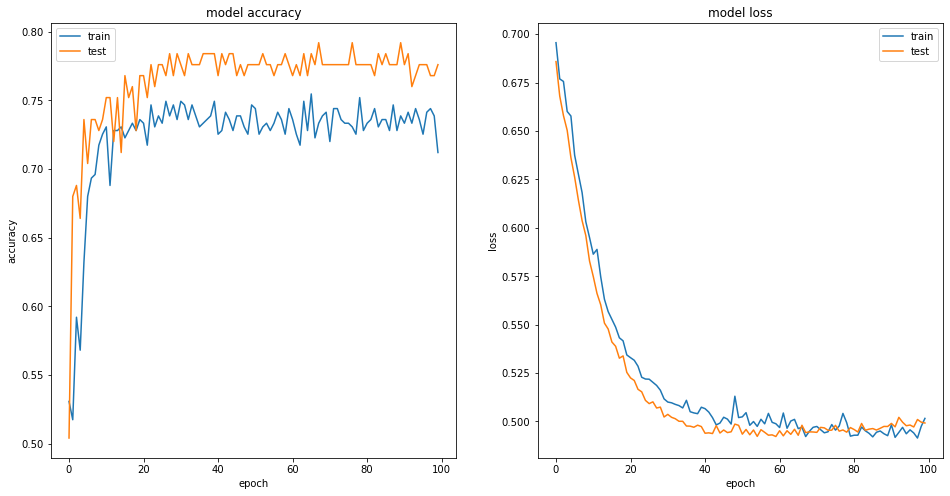

Maximum Loss : 0.6956

Minimum Loss : 0.4914

Loss difference : 0.2042

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        63
           1       0.75      0.82      0.78        62

    accuracy                           0.78       125
   macro avg       0.78      0.78      0.78       125
weighted avg       0.78      0.78      0.78       125



In [24]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.05 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.4767, accuracy: 74.1333%
Evaluating on tests set...
loss=0.5303, accuracy: 76.0000%


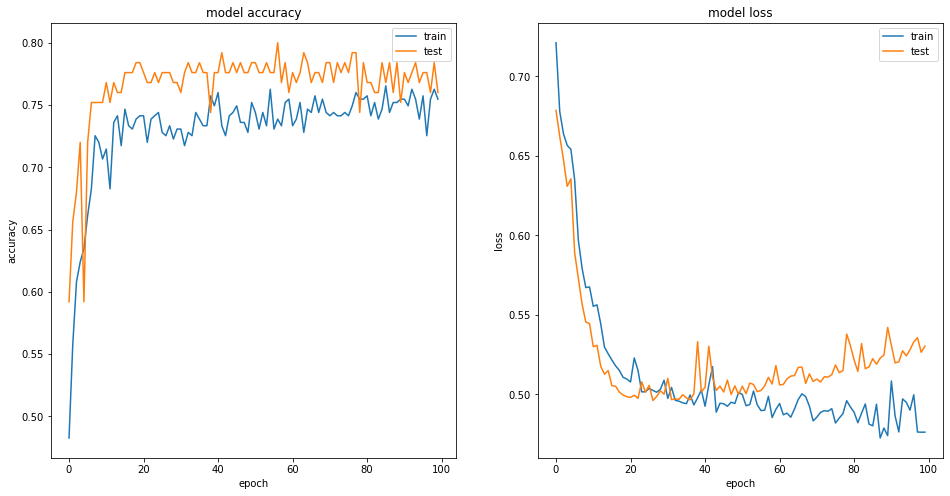

Maximum Loss : 0.7211

Minimum Loss : 0.4725

Loss difference : 0.2486

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        63
           1       0.75      0.77      0.76        62

    accuracy                           0.76       125
   macro avg       0.76      0.76      0.76       125
weighted avg       0.76      0.76      0.76       125



In [25]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.1 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.4075, accuracy: 79.2000%
Evaluating on tests set...
loss=0.6893, accuracy: 75.2000%


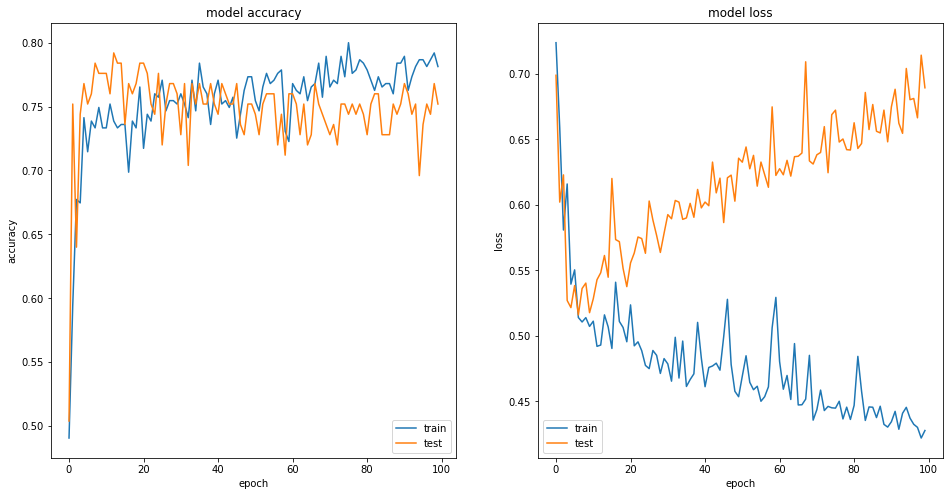

Maximum Loss : 0.7237

Minimum Loss : 0.4219

Loss difference : 0.3018

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        63
           1       0.71      0.84      0.77        62

    accuracy                           0.75       125
   macro avg       0.76      0.75      0.75       125
weighted avg       0.76      0.75      0.75       125



In [26]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.5 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Se puede observar que al cambiar el "learning_rate" la precisión aumenta pero la diferencia del loss aumenta conforme aumentamos el valor de "learning_rate".

Ahora se variará el "momentum" para valores de 0.3, 0.6, 0.9, 1.0 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.6806, accuracy: 61.3333%
Evaluating on tests set...
loss=0.6829, accuracy: 60.8000%


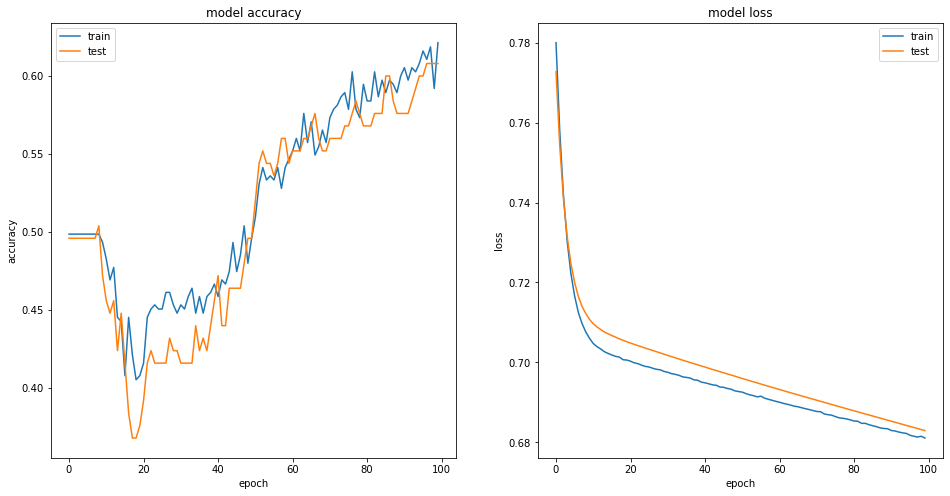

Maximum Loss : 0.7800

Minimum Loss : 0.6811

Loss difference : 0.0989

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        63
           1       0.59      0.66      0.63        62

    accuracy                           0.61       125
   macro avg       0.61      0.61      0.61       125
weighted avg       0.61      0.61      0.61       125



In [27]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 0.3

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.6511, accuracy: 67.7333%
Evaluating on tests set...
loss=0.6430, accuracy: 72.8000%


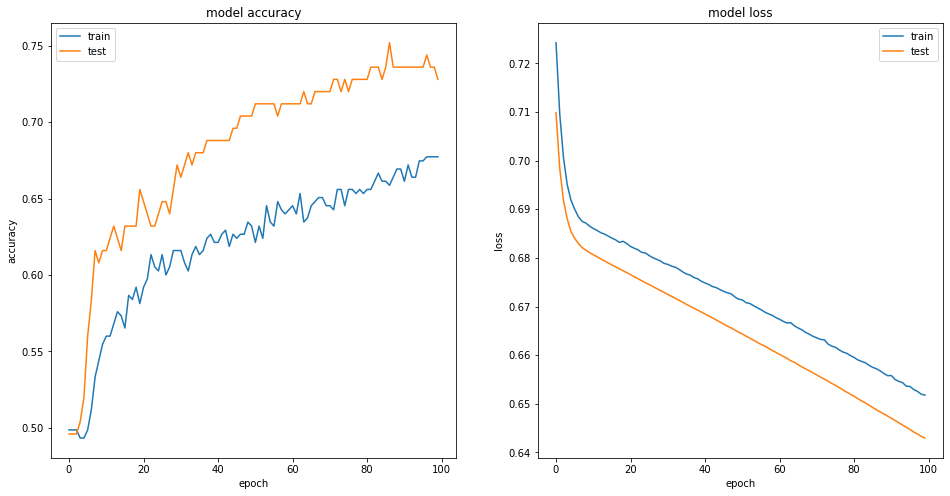

Maximum Loss : 0.7242

Minimum Loss : 0.6518

Loss difference : 0.0724

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        63
           1       0.75      0.68      0.71        62

    accuracy                           0.73       125
   macro avg       0.73      0.73      0.73       125
weighted avg       0.73      0.73      0.73       125



In [28]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 0.6

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.5375, accuracy: 72.8000%
Evaluating on tests set...
loss=0.5267, accuracy: 76.0000%


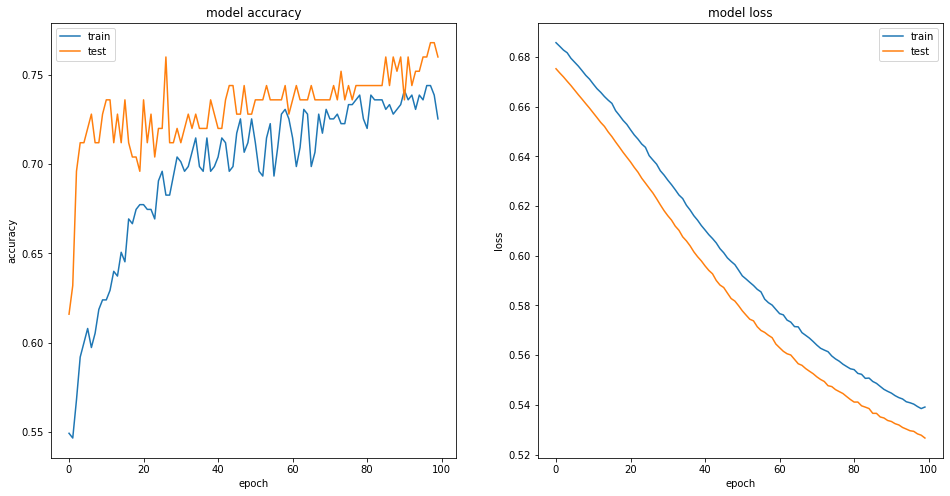

Maximum Loss : 0.6857

Minimum Loss : 0.5385

Loss difference : 0.1472

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        63
           1       0.72      0.85      0.78        62

    accuracy                           0.76       125
   macro avg       0.77      0.76      0.76       125
weighted avg       0.77      0.76      0.76       125



In [29]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.4893, accuracy: 72.8000%
Evaluating on tests set...
loss=0.9294, accuracy: 78.4000%


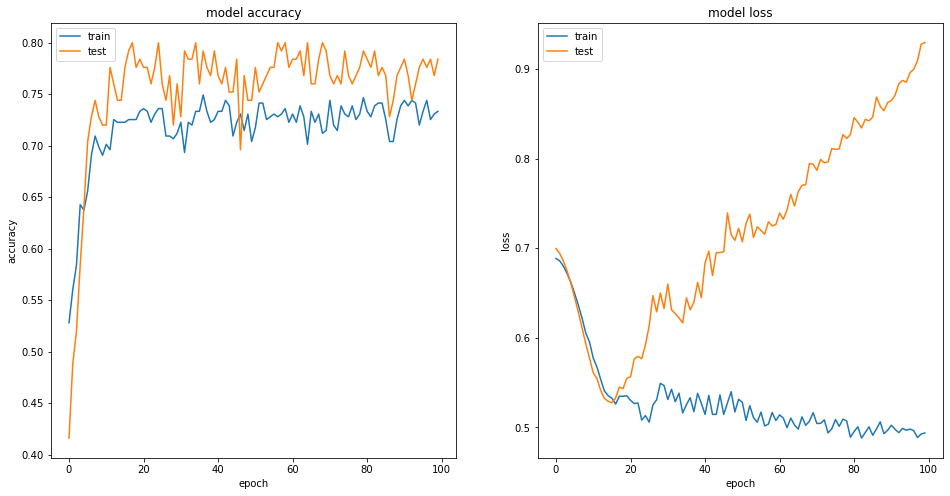

Maximum Loss : 0.6885

Minimum Loss : 0.4880

Loss difference : 0.2005

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        63
           1       0.78      0.79      0.78        62

    accuracy                           0.78       125
   macro avg       0.78      0.78      0.78       125
weighted avg       0.78      0.78      0.78       125



In [30]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.01 # The learning rate
momentum = 1

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Al variar el momentum vemos que la precisión fluctúa al aumentar el valor. Sin embargo al utilizar el valor de 1.0 la diferencia del "loss" aumenta considerablemente.

Hasta el momento se ha encontrado que los mejores resultados se han obtenido usando los valores:

drop = 0.0

learning_rate = 0.05

momentum = 0.9

Probaremos estos valores de los hiperparámetros para dos hidden layers.

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_25 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.4954, accuracy: 75.7333%
Evaluating on tests set...
loss=0.5041, accuracy: 79.2000%


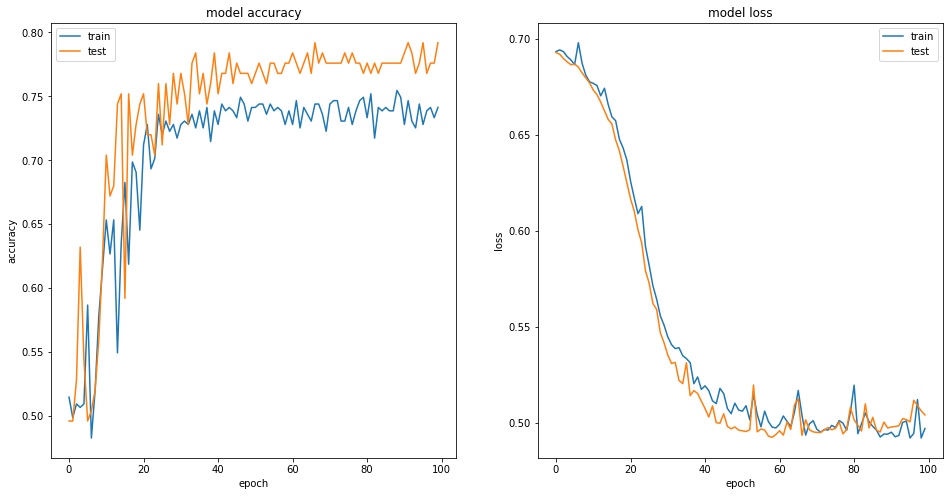

Maximum Loss : 0.6981

Minimum Loss : 0.4921

Loss difference : 0.2060

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.88      0.68      0.77        63
           1       0.74      0.90      0.81        62

    accuracy                           0.79       125
   macro avg       0.81      0.79      0.79       125
weighted avg       0.81      0.79      0.79       125



In [31]:
#Función de activación
activ = "sigmoid" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 2
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.05 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Al utilizar 2 hidden layers la precisión del modelo aumento.

Repetiremos el entrenamiento utilizando los hiperparámetros mencionados previamente para 1 y 2 hidden layers utilizando la función de activación "relu".

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.4240, accuracy: 77.3333%
Evaluating on tests set...
loss=0.6744, accuracy: 75.2000%


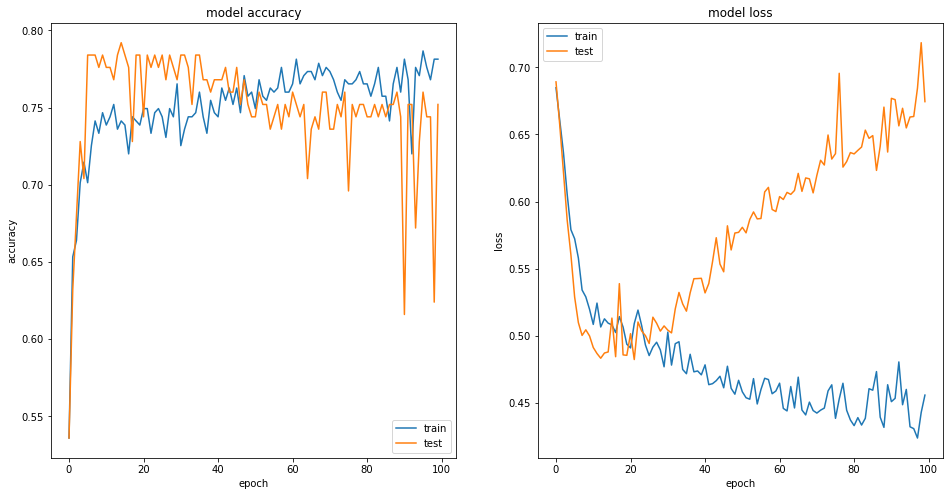

Maximum Loss : 0.6848

Minimum Loss : 0.4238

Loss difference : 0.2610

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        63
           1       0.72      0.81      0.76        62

    accuracy                           0.75       125
   macro avg       0.76      0.75      0.75       125
weighted avg       0.76      0.75      0.75       125



In [32]:
#Función de activación
activ = "relu" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 1
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.05 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_30 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________
Evaluating on training set...
loss=0.3704, accuracy: 80.8000%
Evaluating on tests set...
loss=0.7131, accuracy: 76.8000%


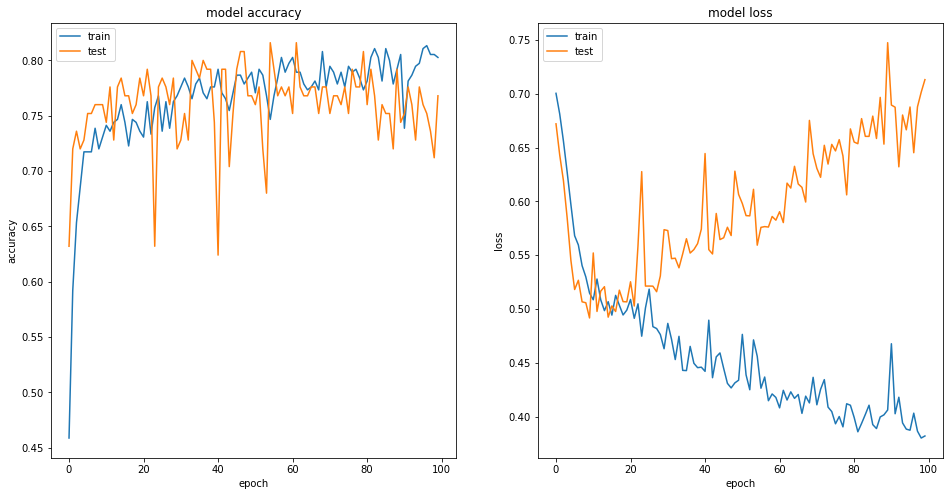

Maximum Loss : 0.7004

Minimum Loss : 0.3801

Loss difference : 0.3202

Comparamos los resultados al evaluar la muestra de prueba con los valores reales
              precision    recall  f1-score   support

           0       0.85      0.65      0.74        63
           1       0.71      0.89      0.79        62

    accuracy                           0.77       125
   macro avg       0.78      0.77      0.77       125
weighted avg       0.78      0.77      0.76       125



In [33]:
#Función de activación
activ = "relu" #"sigmoid" o "relu"
#Número de hidden layers2
hidd = 2
#Dropout
drop = 0.
#Hiperparámetros
training_epochs = 100 # Total number of training epochs
learning_rate = 0.05 # The learning rate
momentum = 0.9

red(x_train5, x_test5, y_train5, y_test5, training_epochs, learning_rate, momentum, activ, hidd, drop)

Podemos observa que la función de activación mostró una mejor precisión del modelo, siendo mayor al usar una hidden layers.

Correremos una última vez el código pero ahora aumentando la cantidad de training_epochs

<h3> Conclusión

El modeló obtenido por la red neuronal mostró una precisión aceptable considerando que los datos no mostraban una corelación en un primer análisis. El modelo permite estimar si un paciente pudiera padecer un derrame cerebral (stroke) en base a su historial médico y personal. Cabe resaltar que a pesar de que la muestra de datos contara con más de 5000 pacientes fue necesario trabajar solo con 500 ya que aquellos que habían padecido un derrame cerebral eran muy pocos en comparación a la muestra total. Por esta razón se cree necesario una muestra de datos más robusta y completa para poder entrenar el modelo. 

De ser posible este modelo sería capaz de informar si un paciente presenta probabilidad de padecer de un derrame cerebral en base a su historial, y serviría como un primer diagnóstico o informe para el médico. 